# Snowflake - Design Justification

## What does it do?

This Christmas decoration has an LED in the centre and two rings of six LEDs. The idea is to blink them, following the pattern centre - inner ring - outer ring - pause.

### LED sequence

To alternate between LEDs, we use a decade counter. The `HC4017` is a Johnson counter with 10 decoded outputs. Only one output is high at a time, and the each output is sequentially selected on the low-to-high edge of the clock signal.

<p align="center"> <img src="img/Counter.png" width="300px"> </p>


In order to cycle through the different elements, the central LED (LED0) is connected to output 1, the inner ring is connected to output 2 and the outer ring is connected to output 3. Output 0 is left unconnected to provide a pause between cycles (and also reduce a bit the average battery draw). Output 4 is connected to the reset pin, so as soon as it gets active, the counter resets and the cycle starts again.

### Clock Generation

To generate the clock signal, we use an Op Amp in astable vibrator configuration. It's made by two elements, a Schmitt trigger and an RC circuit connected to the inverting pin of the opamp. Because we are using a single rail to power the op amp, we have to bias the non-inverting pin.

<p align="center"> <img src="img/Clock.png" width="400px"/> </p>

#### Schmitt Trigger

The Schmitt trigger is formed by the opamp U1A and R3 as feedback resistor and R1 and R2 used as voltage divider to set the bias point. The opamp is powered by the battery directly and V- is connected to GND. As the voltage of the battery will drop, I decided not to use a voltage reference for the bias, because as VDD drops, the ratio between VDD and Vbias would change. The voltage divider affects the Schmitt trigger, by changing the value of the threshold levels, but we need hysteresis anyway.

The analysis is pretty simple. If Vout (labelled CLK) is high, the equivalent circuit is 

<p align="center"> <img src="img/Schmitt_OutputHigh.png" width="200px"> </p>

Doing some basic Kirchoff...

$$
\frac{(VDD - Vbias)}{(R1 // R3)} = \frac{Vbias}{R2} \Rightarrow \frac{Vdd}{Vbias} - 1 = \frac{(R1 // R3)}{R2} \Rightarrow Vbias = \frac{Vdd}{\frac{(R1//R3)}{R2}+1}
$$

Similarly, when the output is low

<p align="center"> <img src="img/Schmitt_OutputLow.png" width="200px"> </p>

$$
\frac{(VDD - Vbias)}{R1} = \frac{Vbias}{(R2 // R3)} \Rightarrow \frac{Vdd}{Vbias} - 1 = \frac{R1}{(R2 // R3)} \Rightarrow Vbias = \frac{Vdd}{\frac{R1}{(R2 // R3)}+1}
$$

If $R1 = R2$, $Vbias = VDD/2$ . It's easy to see how in that case, when the output is low, the feedback resistor pushes the threshold voltage (Vbias) up from whatever the R1 - R2 voltage divider would set by appearing in parallel to R1 (thus, decreasing its value and typing the balance towards R2). In the same way, when the output is high, by appearing in parallel to R2, it lowers Vbias.

The following code shows an interactive plot that allows changing the values of R1, R2 and R3 and see how they impact the threshold levels.

interactive(children=(IntSlider(value=10000, description='R1 (Ω):', max=50000, min=1000, readout_format='.2d',…

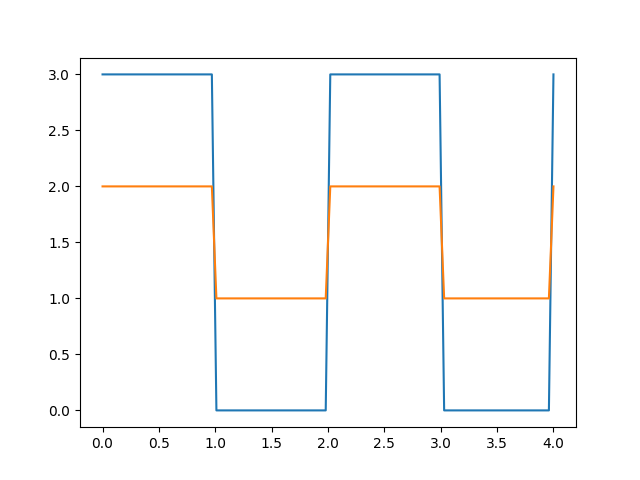

In [1]:
""" Schmitt Trigger interactive plot
"""
%matplotlib widget
from ipywidgets.widgets import IntSlider, FloatSlider, Textarea
from ipywidgets import interact
from math import ceil, exp
from matplotlib.lines import Line2D
from matplotlib.pyplot import figure
from numpy import float64, linspace, pi, sign, sin, array, greater
from numpy.typing import NDArray
from scipy import signal
from scipy.signal import argrelextrema
from typing import Sequence

def ThresholdCalculator(Vdd:float, R1: int, R2: int, Rf: int)-> tuple[float, float]:
    """ Calculates the threshold voltage on a Schmitt trigger (single rail,
    biased with a voltage divider, ideal rail to rail opamp)
    Parameters:
    -----------
        VoutH: float
            The value of VoutH when the opamp is saturated high
        VoutL: float 
            The value of VoutH when the opamp is saturated low
        Vdd: floag
            the power supply voltage
        R1: int
            top resistor of the voltage divider
        R2: int
            bottom resistor of the voltage divider
        Rf: int
            feedback resistor
    Return
    ------
        VthL: float
            the threshold value when the output is LOW
        VthH: float
            the thershokd value when the output is HIGH
    """
    parallelR1Rf:float= (R1 * Rf) / (R1 + Rf)
    parallelR2Rf:float= (R2 * Rf) / (R2 + Rf)
    ratioH:float = (parallelR1Rf / R2) + 1
    ratioL:float = (R1 / parallelR2Rf) + 1
    VthH:float = Vdd / ratioH
    VthL:float = Vdd / ratioL
    return VthL, VthH 

def ThresholdSignal(Vout: Line2D, VthL: float, VthH:float, Vdd: float)-> Sequence[float]:
    """ Calculates the threshold voltage signanl on a Schmitt trigger (single rail,
    biased with a voltage divider)
    Parameters:
    -----------
        Vout: float
            a line 2D with the values of the output signal of the opAmp, as
            they determine the threshold value
        VthL: float
            the threshold value when the output is LOW
        VthH: float
            the thershokd value when the output is HIGH
        Vdd: int
            the power supply voltage
    Return
    ------
        returnArray: Sequence[float]
            a sequence with the values of the Schmitt Trigger thresholds, depending
            on the values of the resistor network, Vdd and the current output of
            the OpAmp
    """
    returnArray:Sequence[float] = []
    # extrac data from Vout (line2D) to array 
    voltages:Sequence[float] = Vout.get_ydata()
    for i in range(len(voltages)):
        if voltages[i] > (Vdd / 2):
            returnArray.append(VthH)
        else:
            returnArray.append(VthL)
    return returnArray

def capacitor_voltage(t:float, R: int, C: float, Vapplied:float)->float:
    """ Calculates the voltage of a capacitor (Vout) in an RC filter after 
    time = t seconds, when Vapplied volts are applied at the input
    Parameters:
    -----------
        t: float
            time elapsed in seconds since Vapplied was applied at the input of 
            the RC filter
        R: int
            The value of the resistor (in Ω) of the RC filter
        C: float
            The value of the capacitor (in Farads) of the RC filter
        Vapplied: float
            The voltage (in Volts) applied at the input
    Retunr
    --------
        cap_Volt: float
            The voltage in the capacitor in Volts (Vout of the RC filter)
    """
    cap_volt = Vapplied * (1 - exp (-t/(R*C)))
    return cap_volt

def astable_vibrator_signals(times:NDArray[float64], Rd1:int, Rd2:int, Rf:int, Rc:int, C:float, Vdd:float)->tuple[Sequence[float], Sequence[float], Sequence[float]]:
    """ Calculates the values of the signals of interest on an Astable Multivibrator: the 
    voltages at the inverting and non inverting pins and the output signal. The amplifier
    is ideal, powered with a single rail and biased with a voltage divider.
    The calculations are based on the values of the feedback resistor Rf, the values of the
    resistors on the voltage divider and the values of the RC filter in the non-inverting pin
    as well as the Vdd voltage.
    Parameters:
    -----------
        times: NDArray[float64]
            A sequence of values for the time at wich the values of the signals has to be calculated
        Rd1:int
            The value of the voltage divider resistor connected to VDD
        Rd2:int
            The value of the voltage divider resistor connected to GND
        Rf:int
            The value of the feedback resistor connected from out to v+.
        Rc: int
            The value of the resistor (in Ω) connected to the RC filter
        C: float
            The value of the capacitor (in Farads) in the RC filter
        Vdd: float
            the voltage applied to the capacitor. It's constant for all the values in times
    Return
    ------
        [vi_signal, vo_signal, vf_signal]: tuple[Sequence[float],Sequence[float],Sequence[float]
            Sequences with the values of voltage at the inverting, output and non-inverting
            pins of the OpAmp, respectively.
    """
    vi_signal:Sequence[float] = [0.0] * len(times)
    vo_signal:Sequence[float] = [0.0] * len(times)
    vf_signal:Sequence[float] = [0.0] * len(times)

    # Get the schimtt trigger thresholds for this config
    thresholdl, thresholdh = ThresholdCalculator(Vdd, Rd1, Rd2, Rf)
    
    #initial conditions
    vi_signal[0] = 0 # capacitor starts discharged
    # vi below threshold, so vo is HIGH
    vo_signal[0] = Vdd
    # vo is HIGH so Vthreshold is VthH
    vf_signal[0] = thresholdh
    start_t = times[0]
    start_v = 0
    rising = False # an aux variable to keep track if we are charging or discharging C
    if vi_signal[0] < vf_signal[0]:
        rising = True
    
    for i in range(1, len(times)): #skip times[0] as we have entered the initial conditions by hand
        if vi_signal[i - 1] < vf_signal[i-1]:
            # If v- < v+, the voltage at the cap is below trheshold
            # We will charge the capacitor
            time = times[i]
            vi_signal[i] = capacitor_voltage(time-start_t, Rc, C, Vdd - start_v) + start_v 
            vf_signal[i] = thresholdh
            vo_signal[i] = Vdd
        else: # vi_signal[i - 1] >= vf_signal[i-1]:
            # Else, the voltage at the cap is above the trheshold
            # We will discharge the capacitor
            time = times[i]
            vi_signal[i] = capacitor_voltage(time-start_t, Rc, C, 0 - start_v) + start_v 
            vf_signal[i] = thresholdl
            vo_signal[i] = 0
        # after updating the values, check if we switched the thresholds
        if (vi_signal[i] >= vf_signal[i]) and rising:
            start_v = thresholdh
            start_t = times[i]
            rising = False
        elif (vi_signal[i] <= vf_signal[i]) and not rising:
            start_v = thresholdl
            start_t = times[i]
            rising = True
    return vi_signal, vo_signal, vf_signal

# Resistor Values and VDD
R_1 = 10000
R_2 = 10000
R_3 = 10000
Vdd = 3
# x axis is 0 to 4s, 100 values
x = linspace(0, 4, 100)
fig = figure()
ax = fig.add_subplot(1, 1, 1)
# Generate a square signal, simulating the switching output of the opamp, .5Hz
out_signal, = ax.plot(x, 3/2 * (signal.square(2 * pi * 1/2 * x) + 1))
# Calculate the threshold values for the resistor network and the output signal
thresholdl, thresholdh = ThresholdCalculator(Vdd, R_1, R_2, R_3) 
threshold_signal, = ax.plot(x, ThresholdSignal(out_signal, thresholdl, thresholdh, Vdd))

def update(R1:int=1, R2:int=1, R3:int=1):
    thresholdl, thresholdh = ThresholdCalculator(Vdd, R1, R2, R3) 
    print(f"Threshold low is {thresholdl:.2f}V and threshold high is {thresholdh:.2f}V. Ratio is {100 * (thresholdh - thresholdl) / Vdd:.0f}% of VDD")
    threshold_signal.set_ydata(ThresholdSignal(out_signal, thresholdl, thresholdh, Vdd))
    fig.canvas.draw_idle()

# Create a wiget for
R1 = IntSlider(value=10000, min=1000, max=50000, step=1000, description='R1 (Ω):', 
    orientation='horizontal', readout=True, readout_format='.2d')
R2 = IntSlider(value=10000, min=1000, max=50000, step=1000, description='R2 (Ω):', 
    orientation='horizontal', readout=True, readout_format='.2d')
Rf = IntSlider(value=10000, min=1000, max=50000, step=1000, description='Rf (Ω):', 
    orientation='horizontal', readout=True, readout_format='.2d')
thresholdL = Textarea(
    value='"0"',
    placeholder='"0"',
    description='String:',
)
interact(update, R1=R1, R2=R2, R3=Rf);

From this experiment, R1 = R2 = R3 seem like a good compromise. The threshold levels for Vdd = 3V are 1V and 2V. The hysteresis is 1V, 33% of the VDD value. And this will simplify construction and the BOM, as we will need less resistor values.

#### Astable Multivibrator

To complete the astable vibrator circuit, we need an oscillating input. We will use the output of the opamp to charge and discharge an RC filter, and connect the capacitor to the inverting input of the opamp. Because the input is not stable in any state, the output will keep oscillating, which in turn will keep the input oscillating... you get the drill.

At the start, the capacitor is discharged, so the inverting input is at 0. The non-inverting input is biased at VDD/2, so the output of the opamp is high, and the voltage at the non-inverting input is set to VthresholdH through the feedback resistor. The output of the opamp starts charging the capacitor

$$V_{cap} = V_{applied} * (1 - e ^{ (-t/(R*C))}) $$

Eventually, $V_{cap} \gt V_{thresholdH}$, so the output of the opamp will go low, the voltage in $V_{+}$ will be set at $V_{thresholdL}$ and the capacitor wills start to discharge through $R$, until $V_{cap} \le V_{thresholdL}$ and the cicle starts again.

The first rise to $V_{thresholdH}$ will take longer, because the cap has to charge from 0V to $V_{thresholdH}$, but after that, the output of the opamp will be a square wave with a 50% duty cycle.

The next code will generate an interactive plot allowing changing the values for all the passives in the circuit.

interactive(children=(IntSlider(value=10000, description='Rd1 (Ω):', max=500000, min=1, step=10000), IntSlider…

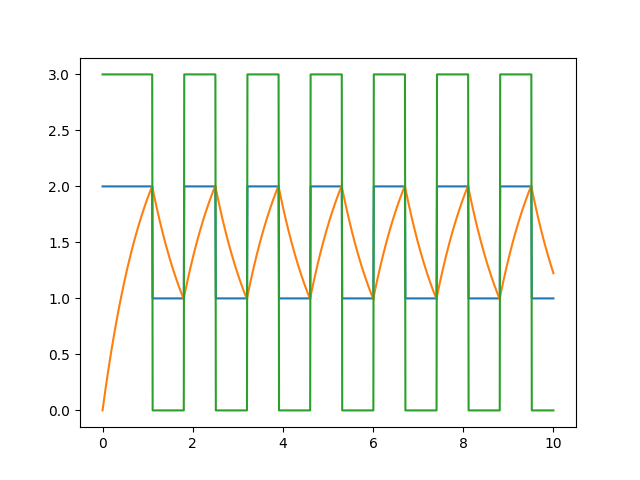

In [6]:
""" Astable Multivibrator Graphs
Putting it all together, shows an interactive plot where we can see the impact of the different
variables of the circuit have on the output.
"""
Rd1:int = 10000
Rd2:int = 10000
Rf:int = 10000
Rcap:int = 100000
cap:float = 0.00001
Vdd:float = 3

start_t = 0
stop_t = 10
delta_t = .01
times = linspace(start_t, stop_t, ceil((stop_t - start_t) / delta_t))

# Prepare the plot
fig = figure()
ax = fig.add_subplot(1, 1, 1)

# Generate the three signals to print
vi_values, vo_values, vf_values = astable_vibrator_signals(times, Rd1, Rd2, Rf, Rcap, cap, Vdd)
vf_signal, = ax.plot(times, vf_values)
vi_signal, = ax.plot(times, vi_values)
vo_signal, = ax.plot(times, vo_values)

def update(Rd1:int, Rd2:int, Rf:int, Rcap:int, cap:float, Vdd:int):
    # update the signal
    vi_upd_values, vo_upd_values, vf_upd_values = astable_vibrator_signals(times, Rd1, Rd2, Rf, Rcap, cap/100000, Vdd)
    vf_signal.set_ydata(vf_upd_values)
    vo_signal.set_ydata(vo_upd_values)
    vi_signal.set_ydata(vi_upd_values)
    # Print the freq/period of the resulting output signal
    # get the indices of the local maxima of vi
    vi_local_maxes=(argrelextrema(array(vi_upd_values), greater, mode='wrap'))[0]
    # the period is the time different between the first two
    clk_period = times[vi_local_maxes[1]] - times[vi_local_maxes[0]]
    print(f"Clk Freq is {1/clk_period:.2f} Period {clk_period}")
    fig.canvas.draw_idle()

# Create a widgets for variables that will be modifiable
Rd1_slider = IntSlider(value=10000, min=1, max=500000, step=10000, description='Rd1 (Ω):', 
    orientation='horizontal', readout=True, readout_format='d')
Rd2_slider = IntSlider(value=10000, min=1, max=500000, step=10000, description='Rd2 (Ω):', 
    orientation='horizontal', readout=True, readout_format='d')
Rf_slider = IntSlider(value=10000, min=1, max=500000, step=10000, description='Rf (Ω):', 
    orientation='horizontal', readout=True, readout_format='d')
Rcap_slider = IntSlider(value=10000, min=5000, max=50000, step=5000, description='Rcap (Ω):', 
    orientation='horizontal', readout=True, readout_format='d')
cap_slider = FloatSlider(value=10, min=.01, max=100, step=.01, description='C (μF):', 
    orientation='horizontal', readout=True, readout_format='.3f')
Vdd_slider = FloatSlider(value=3, min=0, max=5, step=.1, description='Vdd (V):', 
    orientation='horizontal', readout=True, readout_format='.2f')

interact(update, Rd1=Rd1_slider, Rd2=Rd2_slider, Rf= Rf_slider, Rcap=Rcap_slider, cap=cap_slider, Vdd=Vdd_slider);

#### Astable multivibrator Passive Components Values

I like the idea of not having lots of different resistors on my circuit. The Schmitt trigger is balanced if $R_1 = R_2 = R_f$, so we'll select your ubiquitous 10kΩ resistor for them.

For the RC filter, I think the right rate of blinking should be around 1s, but not everyone might agree so let's use a variable resistor in the RC. With a 4.7μF cap we get a period of 1s with ~15kΩ. Using a 50kΩ pot you could slow it down up to T=3.2s. Because the minimum resistance of a pot is quite low (tens of Ω), we can add a series resistor that works as a lower limit. 10kΩ would be a bit too much (as that would set the minimum period on .6s), but I don't want to add another resistor value and because smd resistors are practically free, I'll trade some space and put two 10ks in parallel to get the minimum resistance to 5kΩ that would result in minimum period of T=.35s

<p align="center"> <img src="img/Clock_With_Values.png" height="300px" title="Clock Circuit with values"> </p>

## Powering it up

The first limitation I found is around power. I wanted to use a AAA coin cell to power them, because they store quite an amount of energy (a typical AAA stores 800-1200 mAh, 750mAh if rechargeable ([Duracell](https://www.batterystation.co.uk/content/datasheets_MSDS/duracell/Duracell%20Rechargeable%20AAA.pdf))) but we would need two to get 3V (when full) and a holder simply doesn't fit in the back and it would be quite bulky...

<p align="center"> <img src="img/AAA_On_PCB_Front.png" height="300px" title="PCB Front with AAA holder"> <img src="img/AAA_On_PCB.png" height="300px" title="PCB with triple A batts"> </p>

So I guess that leaves us with coin cells. They use a different chemistry, so they provide higher voltages, so we can power the whole thing with one instead of two (that's good!), but they are smaller, so they have less net capacity (that's bad!). On a good day, a CR2032 has ~250mA and that's when you barely draw any current (see the graph below). As they get discharged, voltage quickly drops (see graph below) which might be a problem with white LEDs.

<p align="center"> <img src="img/2032DischargeCurves.jpg" width="400px" title="Coin Cell Discharge Curves"> </p>

Using one cell definitely looks better than using triple As, you can't see the battery.

<p align="center"> <img src="img/CR2032x2_On_PCB_Front.png" height="300px" title="Front With Coin Cell"> </p>

Another option would be using two cells in series. That wouldn't "double" the battery life, as the current draw would be the same, but the higher VDD voltage could help to bias a white LED for longer: a single, partially-depleted cell providing 2.2V wouldn't bias a white LED, but two really-depleted cells providing 1.8V each would still give you 3.6V to comfortably bias the LED. Two cells don't look bad either, but it might be too heavy/chunky.

<p align="center"> <img src="img/CR2032x1_On_PCB_Side.png" height="300px" title="One Cell from Side"> <img src="img/CR2032x2_On_PCB_Side.png" height="300px" title="Two Cells from Side"> </p>

NordicRF published a paper that proved that pulsed current demand also helped to provide more energy. The time scales mentioned in the paper are very small for our use case (we don't want to blink in the 10s of ms range) but the planned paused between cycles might give the battery a break and improve battery life.

## Choosing an LED

My first idea was to use white LEDs. They have a relatively high Vf (typically around 3.2V although there are some out there with 2.7V) as they are blue or UV LEDs covered with a phosphor layer. These Vfs are at relatively high currents (20-60mA or even more...), where the LED is the most efficient and designed to operate. Luckily for us, we want to work at a lower bias point because we want to run them at the lowest current possible because 1) we are running on a coin cell and 2) we don't want to light up the entire room.

I'll consider using a coloured LED, as they have smaller Vfs allowing using a small bias resistor, and a white LED, which might require 2 batteries and a bigger bias resistor (so more power lost on the resistor) if their bias point is close to 3V.

About the bias point, because we have two rings of 6 LEDs, the maximum draw will be ~6 * Iled. Let's aim for a current of 5mA, which would leave us with a maximum draw of 30mA.

### Yellow LED

This is the curve of a cheap-and-cheerful 20mA@2.2V Yellow LED ([link to datasheet](https://docs.rs-online.com/2fcb/0900766b8156b2c7.pdf)). The rated luminosity is 100mcd typ, 63mcd min at 20mA.

<p align="center"> <img src="img/Yellow_LED_Bias.png" height="300px" title="Yellow LED If/Vf curves"> <img src="img/Yellow_LED_LightvsCurr.png" height="300px" title="Yellow LED light/If curves"></p>

At 5mA, the voltage drop in the LED is ~2V.

### White LED

I found these Osram white LEDs, which are from a reputable brand and are surprisingly cheap for a white LED. They also operate at 20mA@3.2V, although they are on the coldish side of white, with a temperature of 4K ([link to datasheet - TOPLED E3014 KW DCLMS2.EC](https://docs.rs-online.com/4eb6/A700000007295371.pdf)). It's rated 2800mcd min / 4500 mcd max!! **That's 40x brighter.**

<p align="center"> <img src="img/KW_DCLMS2_Bias.png" height="300px" title="White LED If/Vf curves"> <img src="img/KW_DCLMS2_LightvsCurr.png" height="300px" title="White LED light/If curves"></p>

At 5mA, the voltage drop in the LED is ~2.6V. These LEDs are really efficient, and even at 5mA, they are really bright!

### Limiting Resistor Calculations

This code will calculate the value of the limiting resistors for the LEDs, based on the voltage supplied by the batteries, number of batteries

A coin cell (CR2032) has this typical discharge rates, were voltage almost instantly drops to 2.8V and provides voltage until ~2V


In [7]:

from math import ceil
# For 1 cell and a white LED
print("OSRAM White LED - 1 Cell")
numberOfCells = 1
maxCellVoltage = 2.8
minCellVoltage = 2

ledCurrent = 0.005
ledVoltDrop = 2.6 # @5mA, from Datasheet

resistorVoltDropMax = (maxCellVoltage * numberOfCells) - ledVoltDrop
resistorValueMin = ceil(resistorVoltDropMax / ledCurrent)

print(f"Resistor value for 5mA current at led with fresh cells {resistorValueMin}Ω and will drop {resistorVoltDropMax:.2f}V")
print (f"Power use by LED is {ledCurrent * ledVoltDrop * 1000:.2f}mW and Power wasted in R is {ledCurrent * resistorVoltDropMax * 1000:0.2f}mW")

print("\nOSRAM White LED - 2 Cell")
numberOfCells = 2
maxCellVoltage = 2.8
minCellVoltage = 2

ledCurrent = 0.005
ledVoltDrop = 2.6 # @5mA, from Datasheet

resistorVoltDropMax = (maxCellVoltage * numberOfCells) - ledVoltDrop
resistorValueMin = ceil(resistorVoltDropMax / ledCurrent)

print(f"Resistor value for 5mA current at led with fresh cells {resistorValueMin}Ω and will drop {resistorVoltDropMax:.2f}V")
print (f"Power use by LED is {ledCurrent * ledVoltDrop * 1000:.2f}mW and Power wasted in R is {ledCurrent * resistorVoltDropMax * 1000:0.2f}mW")

print("\nYellow White LED - 1 Cell")
numberOfCells = 1
maxCellVoltage = 2.8
minCellVoltage = 2

ledCurrent = 0.005
ledVoltDrop = 2 # @5mA, from Datasheet

resistorVoltDropMax = (maxCellVoltage * numberOfCells) - ledVoltDrop
resistorValueMin = ceil(resistorVoltDropMax / ledCurrent)

print(f"Resistor value for 5mA current at led with fresh cells {resistorValueMin}Ω and will drop {resistorVoltDropMax:.2f}V")
print (f"Power use by LED is {ledCurrent * ledVoltDrop * 1000:.2f}mW and Power wasted in R is {ledCurrent * resistorVoltDropMax * 1000:0.2f}mW")

print("\nYellow White LED - 2 Cell")
numberOfCells = 2
maxCellVoltage = 2.8
minCellVoltage = 2

ledCurrent = 0.005
ledVoltDrop = 2 # @5mA, from Datasheet

resistorVoltDropMax = (maxCellVoltage * numberOfCells) - ledVoltDrop
resistorValueMin = ceil(resistorVoltDropMax / ledCurrent)

print(f"Resistor value for 5mA current at led with fresh cells {resistorValueMin}Ω and will drop {resistorVoltDropMax:.2f}V")
print (f"Power use by LED is {ledCurrent * ledVoltDrop * 1000:.2f}mW and Power wasted in R is {ledCurrent * resistorVoltDropMax * 1000:0.2f}mW")

OSRAM White LED - 1 Cell
Resistor value for 5mA current at led with fresh cells 40Ω and will drop 0.20V
Power use by LED is 13.00mW and Power wasted in R is 1.00mW

OSRAM White LED - 2 Cell
Resistor value for 5mA current at led with fresh cells 600Ω and will drop 3.00V
Power use by LED is 13.00mW and Power wasted in R is 15.00mW

Yellow White LED - 1 Cell
Resistor value for 5mA current at led with fresh cells 160Ω and will drop 0.80V
Power use by LED is 10.00mW and Power wasted in R is 4.00mW

Yellow White LED - 2 Cell
Resistor value for 5mA current at led with fresh cells 720Ω and will drop 3.60V
Power use by LED is 10.00mW and Power wasted in R is 18.00mW


## LTSPICE Simulation

### One Coin Cell

To see the bias point as the battery drops voltage, we will need to run simulations on LTSpice.

I found this link about how to model LEDs on LTSpice in electronics stackexchange: [Modelling an LED](https://electronics.stackexchange.com/questions/9510/how-do-i-model-an-led-with-spice)

The circuit is as follows

<p align="center"> <img src="img/LTSPice.png" width="300px" title="LTSpice Sim Schematic"> </p>

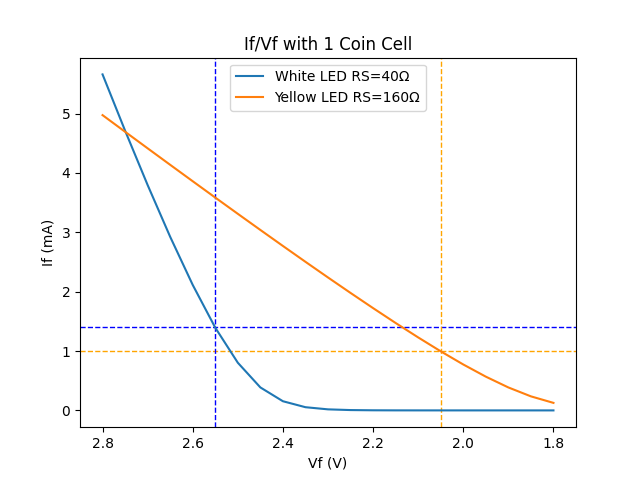

In [59]:
import ltspice
from matplotlib.collections import LineCollection

# Get spice simulation data
filepath = 'LTSpice/LED And Battery Sims 1 Cell.raw'
l = ltspice.Ltspice(filepath)
l.parse() # Data loading sequence. It may take few minutes for huge file.
# Get data from simulation
voltages = l.get_time() # the x axis in the simulation is Voltages, not time
Vwhite = l.get_data('I(D1)')
Vyellow = l.get_data('I(D2)')

fig_spice = figure()
ax_spice = fig_spice.add_subplot(1, 1, 1)

# Plot the two diode curves
whiteLED = ax_spice.plot(voltages, Vwhite * 1000, label="White LED RS=40Ω")
yellowLED = ax_spice.plot(voltages, Vyellow * 1000, label="Yellow LED RS=160Ω")

# plot a dashed lines at the points the light should go off, more or less
ax_spice.axhline(y=1.4, c="blue",linewidth=1,zorder=0, linestyle="dashed")
ax_spice.axhline(y=1, c="orange",linewidth=1,zorder=0, linestyle="dashed")
ax_spice.axvline(x=2.55, c="blue",linewidth=1,zorder=0, linestyle="dashed")
ax_spice.axvline(x=2.05, c="orange",linewidth=1,zorder=0, linestyle="dashed")
#Invert the axis, as it's easier to read "as the battery gets depleted"
ax_spice.invert_xaxis()
ax_spice.set_ylabel("If (mA)")
ax_spice.set_xlabel("Vbatt (V)")
ax_spice.set_title("If/Vbat with 1 Coin Cell")
ax_spice.legend()


In the case of one coin cell, the current would drop below 1mA at @2V in the case of the yellow diode and current is around 2mA@2.55V in the case of the white (the model is not spot on). That means that the white LED is not going to stay lit for long with one cell...

### Two Coin Cells

For the two coin cells, I will use the same circuit, but I will sweep the voltage from 1.8 * 2 to 2.8 * 2.


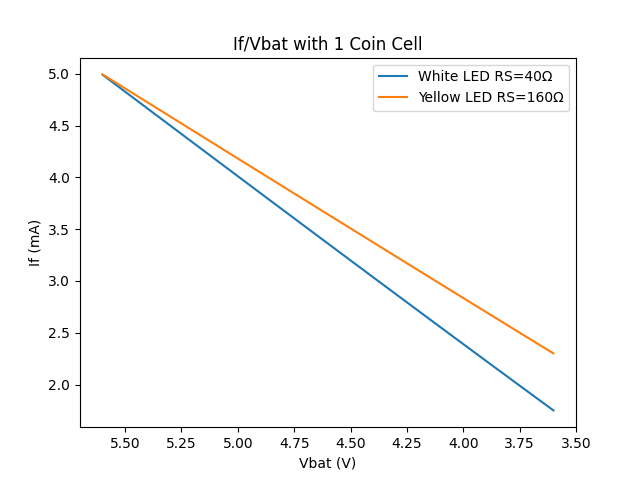

In [60]:
# Get spice simulation data
filepath = 'LTSpice/LED And Battery Sims - Two Cells.raw'
l = ltspice.Ltspice(filepath)
l.parse() # Data loading sequence. It may take few minutes for huge file.
# Get data from simulation
voltages = l.get_time() # the x axis in the simulation is Voltages, not time
Vwhite = l.get_data('I(D1)')
Vyellow = l.get_data('I(D2)')

fig_spice = figure()
ax_spice = fig_spice.add_subplot(1, 1, 1)

# Plot the two diode curves
whiteLED = ax_spice.plot(voltages, Vwhite * 1000, label="White LED RS=40Ω")
yellowLED = ax_spice.plot(voltages, Vyellow * 1000, label="Yellow LED RS=160Ω")
#Invert the axis, as it's easier to read "as the battery gets depleted"
ax_spice.invert_xaxis()
ax_spice.set_ylabel("If (mA)")
ax_spice.set_xlabel("Vbat (V)")
ax_spice.set_title("If/Vbat with 1 Coin Cell")
ax_spice.legend()

With two cells, even when the batteries are depleted, we are still drawing a good 2-2.5mA, so the LEDs will still emit some light. Because of the way voltage drops in a coin cell (non-linearly with a big voltage dip at the end of the cell's life) this might not translate in a significant increase in battery life for the increased price of the extra battery in the case of the Yellow LED, but the white LED can squeeze quite a lot more energy from the batteries.

## Testing it

Let's put it all together and do some tests. The things I want to check are:

* Which pin has to be connected to the reset in the binary counter
* How long do we want to pause between cycles
* What's a good blinking rate that doesn't get annoying
* How bright are the LEDs at different bias currents
* How long does one and two cells last with the different LEDs

### Findings

* 5mA is a lot for the white LEDs, they get bright!, we might have to try with an initial bias of 4mA.

